https://github.com/alura-cursos/1563-treinando-pytorch/blob/aula-04/Carregamento%20de%20Dados.ipynb


Bilbioteca de dados do Pytorch:
torchtext https://pytorch.org/text/stable/index.html
torchvision https://pytorch.org/vision/stable/index.html

In [ ]:
# Carregamento de dados

import torch
from torch import nn, optim

from torchvision import datasets
from torchvision import transforms 
from torchvision import transforms



args = {
    'batch_size': 5,
    'num_workers': 4,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 30
}


if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])

train_set = datasets.MNIST('./', 
                      train=True, 
                      transform=transforms.ToTensor(), 
                      target_transform=None, 
                      download=True)

test_set = datasets.MNIST('./', 
                      train=False, 
                      transform=transforms.ToTensor(), 
                      target_transform=None, 
                      download=False)


print("Amostras de treino :" + str(len(train_set)) + "\nAmostras de teste: " + str(len(test_set)))


cuda
Amostras de treino :60000
Amostras de teste: 10000


<class 'torchvision.datasets.mnist.MNIST'>
<class 'tuple'>


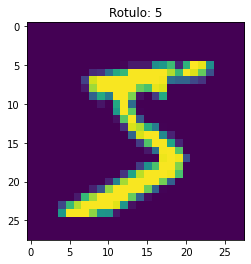

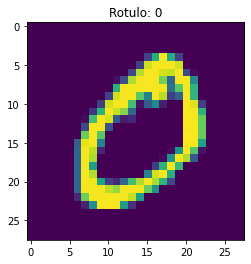

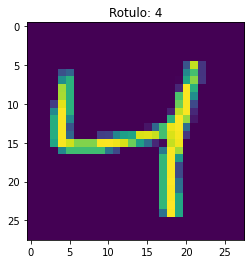

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time


# classe de treino
print(type(train_set))

# cada elemento é uma tupla rotulo:dado
print(type(train_set[0]))


for i in range(3):
  dado, rotulo  = train_set[i]
  plt.figure()
  plt.imshow(dado[0])
  plt.title('Rotulo: '  + str(rotulo))
  plt




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([5, 1, 28, 28]) torch.Size([5])


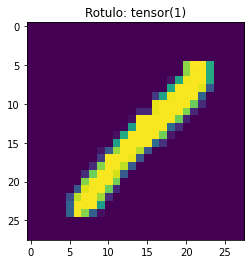

In [ ]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])


train_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])


for batch in train_loader:
  dado, rotulo = batch

  print(dado.size(), rotulo.size())
  plt.imshow(dado[0][0])
  plt.title('Rotulo: ' + str(rotulo[0]))
  break

# batch de tamanho 20
# amostra de tamanho 1/28/18
# ou seja, uma imagem quadrada 28/28 com 1 canal de cor.
# torch.Size([5, 1, 28, 28])


In [ ]:
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features  = nn.Sequential(
                      nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU()
                    )
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()

  def forward(self, X):
    X = X.view(X.size(0), -1)
    feature = self.features(X)
    output  = self.softmax(self.out(feature))

    return output


if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])

input_size = 28*28
hidden_size = 128
out_size = 10 # classes
torch.manual_seed(42)
device = args['device']
net = MLP(input_size, hidden_size, out_size).to(device) # cast na GPU

criterion = nn.CrossEntropyLoss().to(args['device'])
# taxa de aprendizado 10^-4
# wight decay = 5*10^-4
# grid search, random search -> métodos para encontrar bons valores de parâmetros para você
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Fluxo de Treinamento
# 
# Agora vamos aplicar o conhecimento que acabamos de aprender!
# 
# Relembrando o passo a passo do fluxo de treinamento:
# 
#     Iterar nas épocas
#     Iterar nos batches
#     Cast dos dados no dispositivo de hardware
#     Forward na rede e cálculo da loss
#     Cálculo do gradiente e atualização dos pesos
# 
# Para acompanhar a convergência do seu modelo (e garantir que tudo foi feito certinho), ao final de cada época podemos imprimir a média e o desvio padrão das # perdas de cada iteração.

for epoch in range(args['num_epochs']):
  start = time.time()

  epoch_loss = []
  for batch in train_loader:
    
    dado, rotulo = batch

    # Cast na GPU
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward 
    pred = net(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  end = time.time()
  print("Epoca %d, Loss: %.4f +\- %.4f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start) )




cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored

In [ ]:
# Carregando dados customizados no pytorch

import torch
from torch import nn, optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import time
import os

# Configurando hiperparâmetros.
args = {
    'epoch_num': 200,     # Número de épocas.
    'lr': 5e-5,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    'num_workers': 3,     # Número de threads do dataloader.
    'batch_size': 20,     # Tamanho do batch.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

# dados de bicicleata
# https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip  
! ls


df = pd.read_csv('hour.csv')
print(len(df))
df.head()









cuda
--2022-05-27 20:58:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip.1’

Bike-Sharing-Datase 100%[===================>] 273.43K  --.-KB/s    in 0.1s    

2022-05-27 20:58:45 (2.38 MB/s) - ‘Bike-Sharing-Dataset.zip.1’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Readme.txt              
replace day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: day.csv                 
replace hour.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hour.csv                
Bike-Sharing-Dataset.zip    bike_test.csv   day.csv   MNIST	  sample_data
Bike-Sharing-Dataset

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
# permuta aleatoriamente os dados
torch.randperm(10)

torch.manual_seed(1)
# escolhe indices aleatorios para embaralhar os dados
indices = torch.randperm(len(df)).tolist()

# define a porcentagem dos dados que serao dados de treino
train_size = int(0.8*len(df))

# seleciona os dados de 0 até (train_size - 1) para serem dados de treino
print(f"Setar os primeiros {train_size} dados aleatorios em df_train")
df_train = df.iloc[indices[:train_size]]
# seleciona os dados de train_size até o final (len(indices) - 1)
print(f"Setar os ultimos {(len(df) - train_size)} dados aleatorios em df_test.")
df_test = df.iloc[indices[train_size:]]


print("len(df_train):" + str(len(df_train)) + ", len(df_test):" + str(len(df_test)))
display(df_test.head())

# criar os datasets de treino e teste!
df_train.to_csv('bike_train.csv',index=False)
df_test.to_csv('bike_test.csv',index=False)

print("ls current directory...")
! ls







Setar os primeiros 13903 dados aleatorios em df_train
Setar os ultimos 3476 dados aleatorios em df_test.
len(df_train):13903, len(df_test):3476


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12663,12664,2012-06-16,2,1,6,20,0,6,0,2,0.66,0.6212,0.47,0.1940,123,229,352
1801,1802,2011-03-20,1,0,3,18,0,0,0,1,0.38,0.3939,0.40,0.3582,58,98,156
16567,16568,2012-11-28,4,1,11,1,0,3,1,2,0.26,0.2576,0.75,0.2239,0,12,12
8817,8818,2012-01-08,1,1,1,5,0,0,0,2,0.32,0.3333,0.49,0.1045,0,2,2
2608,2609,2011-04-23,2,0,4,14,0,6,0,1,0.58,0.5455,0.78,0.3582,182,209,391


ls current directory...
Bike-Sharing-Dataset.zip    bike_test.csv   day.csv   MNIST	  sample_data
Bike-Sharing-Dataset.zip.1  bike_train.csv  hour.csv  Readme.txt


Tutorial completo do PyTorch: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
class BikeDataset(Dataset):

  def __init__(self, csv_path):
    self.csv_data = pd.read_csv(csv_path).to_numpy()

  def __getitem__(self, idx):
    # 2 ao 14 é o payload
    sample = self.csv_data[idx][2:14]
    # ultimo elemento é o label
    label = self.csv_data[idx][-1:]
    # converter para tensor
    # 1 converte para float32 -> 2 converte de array numpy para tensor
    sample = torch.from_numpy(sample.astype(np.float32))
    label = torch.from_numpy(label.astype(np.float32))
    # obrigatoriamente a saida do dataset é um tipo tupla
    return sample, label

  def __len__(self):
    return len(self.csv_data)

! echo "diretório atual"
! ls
train_set = BikeDataset("bike_train.csv")
test_set = BikeDataset("bike_test.csv")

dado, rotulo = train_set[0]
print("rotulo:" + str(rotulo))
print("condições do dia: " + str(dado))


diretório atual
Bike-Sharing-Dataset.zip    bike_test.csv   day.csv   MNIST	  sample_data
Bike-Sharing-Dataset.zip.1  bike_train.csv  hour.csv  Readme.txt
rotulo:tensor([373.])
condições do dia: tensor([ 4.0000,  1.0000, 11.0000, 19.0000,  0.0000,  4.0000,  1.0000,  1.0000,
         0.3800,  0.3939,  0.2700,  0.3582])


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])

test_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])

for batch in train_loader:

  dado, rotulo = batch
  print('## Dimensionalidade do batch ##')
  print(dado.size(), rotulo.size())
  break
  # plt.title("Rotulo: " + str(rotulo[0]))
  # plt.imshow(dado[0][0])
  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])


In [ ]:
# criando a rede neural
 
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features  = nn.Sequential(
                      nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU()
                    )
    self.out     = nn.Linear(hidden_size, out_size)
    # retirando a ativação, pode-se permitir que a rede aprenda qualquer
    # intervado de valores. 
    # o proposito do softmax é fazer com que no final exista uma probabilidade,
    # que não é o caso. 
    # self.softmax = nn.Softmax()

  def forward(self, X):
    # não é necessário linearizar a entrada, já que ela já
    # vai ter uma unica dimentsão
    # X = X.view(X.size(0), -1)
    feature = self.features(X)
    # não estou usando o softmax, então posso usar somente o linear, sem
    # ativação
    # output  = self.softmax(self.out(feature))
    output = self.out(feature)

    return output


# train_set todas as amostras que serao testadas
len(train_set)
# train_set[0] tensor de uma tupla com o dado e o rótulo
train_set[0]
# somente o dado
train_set[0][0]
# quantos atributos temos no nosso dado
input_size =  len(train_set[0][0])
# manter o mesmo do ex anterior
hidden_size = 128
# numero de variaveis que serão preditas -> uma só variavel,
# quantas bicicletas serão vendidas
out_size = 1 
# Cast da rede neural na GPU se disponível
net = MLP(input_size, hidden_size, out_size).to(args['device'])






In [ ]:
# Definindo loss e otimizador

# loss de regressão
criterion = nn.L1Loss().to(args['device'])

# é possivel utilizar o mesmo otimizador do exeplo anterior
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])




def train(train_loader, net, epoch):

  # Training mode
  net.train()
  
  start = time.time()
  
  epoch_loss  = []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  
  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  
  return epoch_loss.mean()
    


def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

  epoch_loss = np.asarray(epoch_loss)
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  
  return epoch_loss.mean()
    





In [ ]:

n_iter = 10
i = 0
for epoch in range(args['epoch_num']):
  i += 1
  train(train_loader, net, epoch)
  validate(test_loader, net, epoch)
  if i >= n_iter:
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#################### Train ####################
Epoch 0, Loss: 162.1998 +/- 41.4528, Time: 2.62
********** Validate **********
Epoch 0, Loss: 125.0877 +/- 32.2792, Time: 2.60

#################### Train ####################
Epoch 1, Loss: 131.7140 +/- 24.9943, Time: 2.48
********** Validate **********
Epoch 1, Loss: 126.6249 +/- 24.3527, Time: 1.81

#################### Train ####################
Epoch 2, Loss: 122.8945 +/- 31.4290, Time: 2.62
********** Validate **********
Epoch 2, Loss: 129.4849 +/- 32.9525, Time: 1.75

#################### Train ####################
Epoch 3, Loss: 123.1575 +/- 31.6277, Time: 2.52
********** Validate **********
Epoch 3, Loss: 116.4208 +/- 28.3660, Time: 1.76

#################### Train ####################
Epoch 4, Loss: 121.8102 +/- 25.1997, Time: 2.60
********** Validate **********
Epoch 4, Loss: 117.1145 +/- 26.7825, Time: 1.75

#################### Train ####################
Epoch 5, Loss: 119.9313 +/- 29.0956, Time: 2.67
********** Validate ****

In [ ]:
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(args['device'])

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest, ypred), axis=1)

df_results = pd.DataFrame(data, columns=['ypred', 'ytest'])
df_results.head(20)

,ypred,ytest
0,tensor(352.),tensor(325.0928)
1,tensor(156.),tensor(87.0831)
2,tensor(12.),tensor(6.9657)
3,tensor(2.),tensor(-19.6581)
4,tensor(391.),tensor(350.4462)
5,tensor(391.),tensor(335.9232)
6,tensor(84.),tensor(163.1473)
7,tensor(487.),tensor(567.8029)
8,tensor(176.),tensor(326.7634)
9,tensor(157.),tensor(96.5312)
